# Sentiment Anslysis 

## Preparing Dataset:

Check [imdb dataset info](https://github.com/DrJZhou/Datasets-for-Sentiment-Analysis?tab=readme-ov-file#imdb) for more detail on data

In [1]:
import os
import pandas as pd


imdb_path = "/kaggle/input/imdb-sentiment-analysis/aclImdb_v1/aclImdb"

# Function to load reviews from a directory
def load_reviews(directory, label):
    reviews = []
    for filename in os.listdir(os.path.join(imdb_path, directory)):
        if filename.endswith(".txt"):
            with open(os.path.join(imdb_path, directory, filename), "r", encoding="utf-8") as file:
                review_text = file.read()
                reviews.append({"review": review_text, "label": label})
    return reviews

# Load positive and negative reviews from train and test directories
positive_train_reviews = load_reviews("train/pos", label="positive")
negative_train_reviews = load_reviews("train/neg", label="negative")
positive_test_reviews = load_reviews("test/pos", label="positive")
negative_test_reviews = load_reviews("test/neg", label="negative")

# Create Pandas DataFrames
train_df = pd.DataFrame(positive_train_reviews + negative_train_reviews)
test_df = pd.DataFrame(positive_test_reviews + negative_test_reviews)

# Shuffle the DataFrames
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display basic information about the DataFrames
print("Train DataFrame:")
print(train_df.info())
print("\nTest DataFrame:")
print(test_df.info())


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/imdb-sentiment-analysis/aclImdb_v1/aclImdb\\train/pos'

In [3]:
train_df[:5] #first 5 elements(rows!)

,review,label
0,"Sure, for it's super imagery and awesome sound...",positive
1,No words can describe my utter hatred for this...,negative
2,"I watch a lot of films, good, bad and indiffer...",positive
3,one word boring.<br /><br />the young demi loo...,negative
4,I rented this movie roughly 4-5 years ago and ...,negative


In [4]:
# Convert the "label" column to numerical format (e.g., 0 for negative and 1 for positive) to facilitate model training.
if train_df["label"].apply(lambda x: type(x) == str).all(): #checking if labels are in string datatype
    # Label encoding
    print("Label Encoding")
    
    #map: Used for element-wise transformations, often with a dictionary or a function.
    #Used for more complex operations or functions that need to be applied along the axis (either rows or columns) of a DataFrame.
    #Both can be used for similar tasks, but apply provides more flexibility for custom operations.
    
    train_df["label"] = train_df["label"].map({"negative": 0, "positive": 1}) 
    #apply() can also be used instead of map:  .apply(lambda x: {"negative": 0, "positive": 1}.get(x))
    test_df["label"] = test_df["label"].map({"negative": 0, "positive": 1})
else:
    print("already converted")


Label Encoding


In [5]:
train_df[:5]

,review,label
0,"Sure, for it's super imagery and awesome sound...",1
1,No words can describe my utter hatred for this...,0
2,"I watch a lot of films, good, bad and indiffer...",1
3,one word boring.<br /><br />the young demi loo...,0
4,I rented this movie roughly 4-5 years ago and ...,0


**Tokenization is the process of breaking down a sequence of text into smaller units called tokens. Tokens can be as short as characters or as long as words.**

In [6]:
import re #Importing the regular expressions (regex) module for string manipulation.
from nltk.tokenize import word_tokenize # Importing the word_tokenize function from the NLTK library for tokenization.
from nltk.corpus import stopwords # Importing the stopwords module from NLTK for removing common English stopwords.
print("original text: my name is zen//99876 888 and tokenizing is like buidingblock")
text=re.sub(r"[^a-zA-Z0-9]", " ", "my name is zen//99876 888 and tokenizing is like buidingblock") # Remove special characters by replacing them with spaces
print(f"After removing special characters: {text}") 
tokens = word_tokenize(text) # Tokenization of the text into a list of words
print(f"After tokenizing: {tokens}")
tokens = [word for word in tokens if word.isalpha()] # Remove non-alphabetic tokens
print(f"After removing non-alphabetic tokens: {tokens}") 
tokens = [word for word in tokens if word not in stopwords.words("english")] # Remove stopwords
print(f"After removing stopwords like (my,and,...): {tokens}")
print(f"joining list components in string: {' '.join(tokens)}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


original text: my name is zen//99876 888 and tokenizing is like buidingblock
After removing special characters: my name is zen  99876 888 and tokenizing is like buidingblock
After tokenizing: ['my', 'name', 'is', 'zen', '99876', '888', 'and', 'tokenizing', 'is', 'like', 'buidingblock']
After removing non-alphabetic tokens: ['my', 'name', 'is', 'zen', 'and', 'tokenizing', 'is', 'like', 'buidingblock']
After removing stopwords like (my,and,...): ['name', 'zen', 'tokenizing', 'like', 'buidingblock']
joining list components in string: name zen tokenizing like buidingblock


Preprocessing texts

In [7]:
from tqdm.notebook import tqdm
tqdm().pandas(desc="Processing Reviews")


import re
import torch
from torchtext.data.utils import get_tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<br\s*/*\s*><br\s*/*\s*>', '', text)  #r' ' is a raw string representing a single space character. It will match any single space in the text.
    #\s* is a pattern that matches zero or any number whitespace characters.
    #r"[^a-zA-Z0-9]" is a character class that matches any character that is not an uppercase letter, lowercase letter, or digit. The ^ inside the square brackets negates the character class, so it matches any character that is not in the specified set.
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # Remove special characters
    tokenizer = get_tokenizer("basic_english")  # spacy(also add language="en_core_web_sm") , basic_english 
    tokens = tokenizer(text) # Tokenization
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    
    # Custom stopword list excluding 'not'....
    custom_stopwords = set(stopwords.words("english")) - {'not'}
    
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords
    return " ".join(tokens) # Joining the remaining tokens back into a string and return the processed text.

# Apply text preprocessing to reviews 
train_df["processed_review"] = train_df["review"].progress_apply(preprocess_text)
test_df["processed_review"] = test_df["review"].progress_apply(preprocess_text)

# Separate positive and negative reviews
positive_reviews = " ".join(train_df[train_df["label"] == 1]["processed_review"])
negative_reviews = " ".join(train_df[train_df["label"] == 0]["processed_review"])


0it [00:00, ?it/s]

Processing Reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

Processing Reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
# "".join(train_df["processed_review"][:2])  # multiple rows can be joined together using this 


In [10]:
# Display processed data samples
print("Processed Train DataFrame:")
print(train_df[["processed_review", "label"]].head())
print("\nProcessed Test DataFrame:")
print(test_df[["processed_review", "label"]].head())
print(f"\nTotal columns: {train_df.columns}")

Processed Train DataFrame:
                                    processed_review  label
0  sure super imagery awesome sound great home th...      1
1  words describe utter hatred appalling renditio...      0
2  watch lot films good bad indifferent usually s...      1
3  one word boring young demi looks good pregnant...      0
4  rented movie roughly years ago instantly disap...      0

Processed Test DataFrame:
                                    processed_review  label
0  anybody interested black film making like watc...      1
1  really like kinski great actor seen movie hear...      0
2  good see not person remembers great film fond ...      1
3  straight video good reason like neighborhood k...      0
4  reality mafia environment absolutely dog eat d...      0

Total columns: Index(['review', 'label', 'processed_review'], dtype='object')


**Visualizing the most frequent words in the reviews**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


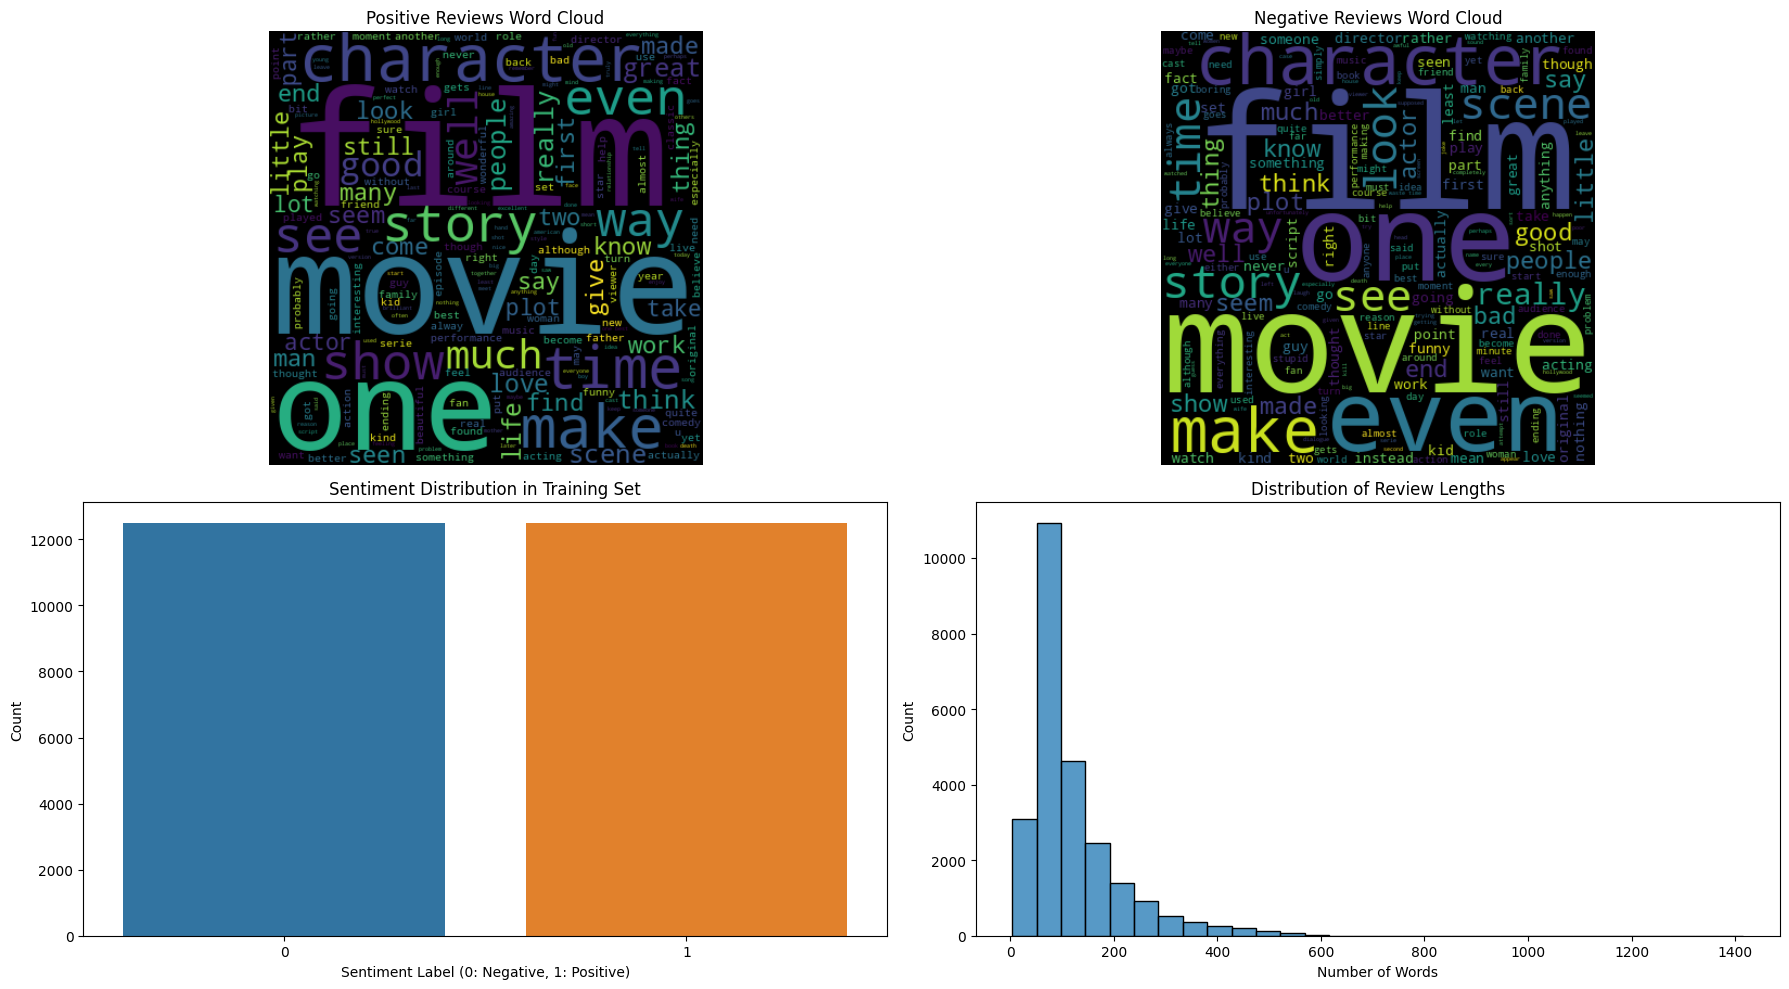

In [11]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# Word clouds
axes[0, 0].imshow(WordCloud(width=400, height=400).generate(positive_reviews), interpolation="bilinear")
axes[0, 0].set_title("Positive Reviews Word Cloud")
axes[0, 0].axis("off")

axes[0, 1].imshow(WordCloud(width=400, height=400).generate(negative_reviews), interpolation="bilinear")
axes[0, 1].set_title("Negative Reviews Word Cloud")
axes[0, 1].axis("off")

# Bar plot of sentiment distribution
sns.countplot(x="label", data=train_df, ax=axes[1, 0])
axes[1, 0].set_title("Sentiment Distribution in Training Set")
axes[1, 0].set_xlabel("Sentiment Label (0: Negative, 1: Positive)")
axes[1, 0].set_ylabel("Count")

# Histogram of review lengths
sns.histplot(train_df["processed_review"].apply(lambda x: len(x.split())), bins=30, kde=False, ax=axes[1, 1])
# KDE is a technique used to estimate the probability density function of a continuous random variable, providing a smooth representation of the data distribution.
axes[1, 1].set_title("Distribution of Review Lengths")
axes[1, 1].set_xlabel("Number of Words")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


**Preprocessing Data for Pytorch:**

>**After Processing and Cleaning the data(like removing stopwords), the top 5000 most frequent words in the entire dataset will be considered as features.(Also known as Feature Extraction: features are selected, extracted, or transformed from raw data to create a more concise and informative representation.)**
>
>*here for converting the reviews data into numerical data, we are basically using feature extraction technique called Count vectorizer to extract and count most used words and turning them in feature list and later it is passed on transform or fit_transform  to apply those features on review data to convert them in numerical format*
>
>`fit-transform or transform` --> `CountVectorizer` --> `Feature Extraction`
>
>vectorizer will consider only the most frequent words from training data during the initial fitting (fit_transform)
>
>Countvectorizer stores vocabulary(basically list of words) as a sparse matrix which only stores non-zero elements along with their positions(index value)


**Later i would also try Word2Vec or  TF-IDF vectorizer but for now i think count vectorizer will be sufficient for my needs**

In [12]:
#Converting the processed reviews into numerical data that can be fed into a PyTorch model.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split the data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_df["processed_review"], train_df["label"], test_size=0.1, random_state=42
)

# Incorporate part of the test set into the training set (using 80% for training)
train_data = pd.concat([train_data, test_df["processed_review"].iloc[:int(0.8 * len(test_df))]])
train_labels = pd.concat([train_labels, test_df["label"].iloc[:int(0.8 * len(test_df))]])

# Use CountVectorizer for text to numerical representation
# `CountVectorizer`: This is the scikit-learn class that performs the tokenization and counts the occurrences of each word in the text.
# we are basically etablishing a fixed vocabulary on which model will try to find patterns
vectorizer = CountVectorizer(max_features=12000)  # max_features: This parameter controls the maximum number of features (words) to be used.

#However, at the point of initialization, it doesn't have any words in its vocabulary yet.
#The vocabulary is learned and populated with words when you apply the fit_transform method on your training data.
#In a sparse matrix, only the non-zero elements are stored along with their positions. but nd array stores every single element of the matrix, including the zeroes.
X_train = vectorizer.fit_transform(train_data).toarray() # using fit_transform for training data
X_val = vectorizer.transform(val_data).toarray() # using transform for evaluation and testing data
X_test = vectorizer.transform(test_df["processed_review"].iloc[int(0.8 * len(test_df)):]).toarray()

# Convert to PyTorch tensors
#Tensors in PyTorch are essentially multi-dimensional arrays. 
y_train = torch.tensor(train_labels.values, dtype=torch.float32)
y_val = torch.tensor(val_labels.values, dtype=torch.float32)
y_test = torch.tensor(test_df["label"].iloc[int(0.8 * len(test_df)):].values, dtype=torch.float32)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create PyTorch datasets and dataloaders   
# TensorDataset is basically collection of multiple tensors
train_dataset = TensorDataset(X_train_tensor, y_train) 
val_dataset = TensorDataset(X_val_tensor, y_val)
test_dataset = TensorDataset(X_test_tensor)

#dataloaders are used to iterate over batches of data during the training and evaluation phases. 
#Dataloaders are essential for efficiently loading and feeding batches of data into the model.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [13]:
#dataset can be directly accessed just like dataframe but data loader cannot be accessed like that
print(f"Total number  of input features(columns) of training dataset(one row, first column) :   {len(train_dataset[1][0]) }")
print(f"len of input rows of training dataset: (all rows, first column)(not counting individual elements of each row) :   {len(train_dataset[:][0]) }")
print(f"len of output rows of training dataset: (all row, second column)(contains only one feature(column) for each row) :   {len(train_dataset[:][1]) }")
print(f"len of data loader(train): {len(train_loader)}")

all_text= " ".join(train_data)
words = all_text.split()
unique_words = set(words)
total_distinct_words = len(unique_words)

print(f"Total distinct words: {total_distinct_words}")

Total number  of input features(columns) of training dataset(one row, first column) :   12000
len of input rows of training dataset: (all rows, first column)(not counting individual elements of each row) :   42500
len of output rows of training dataset: (all row, second column)(contains only one feature(column) for each row) :   42500
len of data loader(train): 665
Total distinct words: 94407


**Reducing the high-dimensional data to just 2 dimensions using PCA may not capture the complex relationships present in the original feature space. In practice, neural networks are powerful tools precisely because they can learn intricate patterns and representations in high-dimensional spaces.**

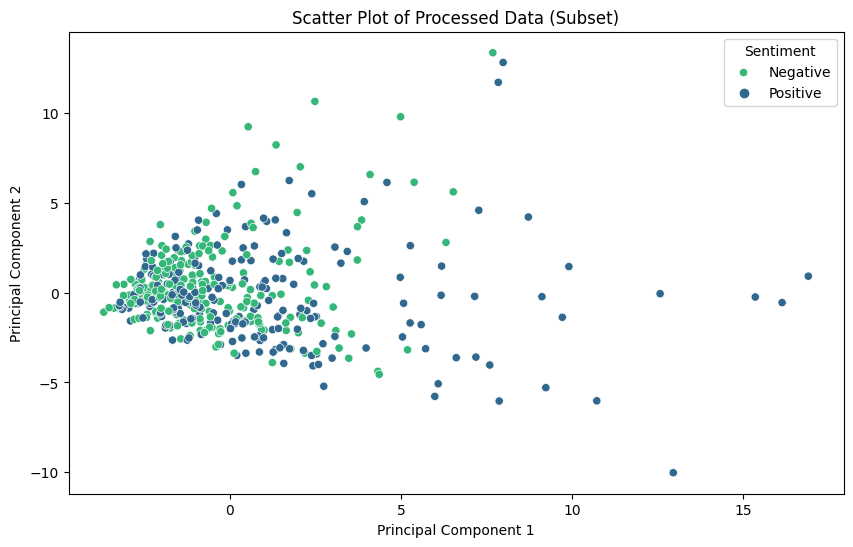

In [14]:
#trying to visualize 5000 features(dimensions) which is not possible even after reducing them to 2 using 
# techniques like pca, in some cases it might be possible but generally it will not be able to fetch 
# important feature's data in 2d so point will overlap each other
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

# Choose a subset of the data for visualization
subset_size = 500
subset_indices = np.random.choice(len(X_train), size=subset_size, replace=False)
X_subset = X_train[subset_indices]
y_subset = train_labels.iloc[subset_indices]  #iloc: integer indexing

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_subset_pca = pca.fit_transform(X_subset)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_subset_pca[:, 0], y=X_subset_pca[:, 1], hue=y_subset, palette="viridis")
plt.title("Scatter Plot of Processed Data (Subset)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sentiment", loc="upper right", labels=["Negative", "Positive"])
plt.show()


# Model

**i should have used cnn architecture so i will most probably update the whole model later**

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#a basic model
class SentimentModel(nn.Module):
    def __init__(self, input_size, hidden_size=32,dropout_rate=0.4):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate), #Dropout is a regularization technique commonly used in neural networks during training to prevent overfitting
            nn.Linear(hidden_size, hidden_size*2), #  linear layer (y=mx+c)
            nn.ReLU(), # max(0,x) , basically adds non-linearity
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*4, hidden_size*8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequential(x)

## better model  
class SentimentCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout_rate=0.4):
        super(SentimentCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=hidden_size*2, out_channels=hidden_size*4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=hidden_size*4, out_channels=hidden_size*8, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*8 * (input_size // 1), 1)  # Adjust the input size for the fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.leaky_relu(self.conv1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc(x))
        return x
    
import torch
import torch.nn as nn
import torch.nn.functional as F

## best model

class SentimentCNNModelV2(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout_rate=0.4, vocab_size=10000, embedding_dim=100):
        super(SentimentCNNModelV2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=hidden_size*2, out_channels=hidden_size*4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=hidden_size*4, out_channels=hidden_size*8, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*8 * (input_size // 1), 1)  # Adjust the input size for the fully connected layer

    def forward(self, x):
        x = x.long()  # Convert input indices to LongTensor
        x = self.embedding(x)  # Convert input indices to embeddings
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, embedding_dim, input_size)
        x = F.leaky_relu(self.conv1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc(x))
        return x
# Instantiate the model
input_size = X_train.shape[1]
model = SentimentCNNModelV2(input_size)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



SentimentCNNModelV2(
  (embedding): Embedding(10000, 100)
  (conv1): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=3072000, out_features=1, bias=True)
)

In [29]:
# Define loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [30]:
from tqdm.notebook import tqdm
import time
from sklearn.metrics import accuracy_score

# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_time = time.time()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}, Time: {end_time - start_time:.2f}s")


# Testing
model.eval()
test_predictions = []
with torch.inference_mode():
    for test_inputs in tqdm(test_loader, desc="Testing"):
        test_inputs = test_inputs[0].to(device)
        test_outputs = model(test_inputs)
        test_predictions.extend(test_outputs.squeeze().cpu().numpy()) # append elements

# Convert predictions to binary labels
test_predictions = torch.tensor(test_predictions)
binary_predictions = test_predictions.round().int().numpy()


# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test.cpu().numpy(), binary_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/5:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 1/5, Avg Loss: 0.4937, Time: 113.81s


Epoch 2/5:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 2/5, Avg Loss: 0.2696, Time: 113.65s


Epoch 3/5:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 3/5, Avg Loss: 0.2242, Time: 113.53s


Epoch 4/5:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 4/5, Avg Loss: 0.1992, Time: 113.56s


Epoch 5/5:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 5/5, Avg Loss: 0.1794, Time: 113.50s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 0.8898


**Evaluating**

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_classification_metrics(y_true, y_pred):
    """
    Calculate precision, recall, and F1 score.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Returns:
    - precision: Precision score.
    - recall: Recall score.
    - f1: F1 score.
    """

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Model evaluation loop
model.eval()
predictions = []

with torch.inference_mode():
    for inputs in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())

# Convert predictions to binary labels
predictions = torch.tensor(predictions)
binary_predictions = (predictions >= 0.5).int().numpy()

# Evaluate metrics (you can use the evaluation function you defined earlier)
precision, recall, f1 = evaluate_classification_metrics(y_val.cpu().numpy(), binary_predictions)

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Validation Precision: 0.9013
Validation Recall: 0.8701
Validation F1 Score: 0.8854


got around 90% accuracy

In [33]:
# Testing
input_text = "not okay"

# Preprocess the input text
processed_text = preprocess_text(input_text)

# Convert processed text to input features using the vectorizer
input_features = vectorizer.transform([processed_text]).toarray()

# Convert to PyTorch tensor
input_tensor = torch.tensor(input_features, dtype=torch.float32).to(device)

# Make prediction
with torch.inference_mode():
    model.eval()
    output = model(input_tensor)

print(output)
# Interpret the result (assuming binary classification)
predicted_class = 1 if output.item() > 0.5 else 0

# Print the result
print("Predicted Sentiment:", "Positive" if predicted_class == 1 else "Negative")


tensor([[0.3365]], device='cuda:0')
Predicted Sentiment: Negative


# Saving the model

In [34]:
torch.save(model, 'sentiment_model.pth')

In [35]:
import joblib

#saving vocabulary 
joblib.dump(vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']